Training is not going below 0.8 loss. Why? Generations are almost all exactly the data.

Therefore
1. Train on the data
2. Manually test training results

In [1]:
import torch
import torch.nn as nn
from CircuitSimulation.CircuitSimulator import *
import numpy as np
from diffusers import UNet2DConditionModel
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap
import hashlib
from itertools import combinations
from tqdm import tqdm

In [4]:
# Set dataset

InitialDataset = torch.tensor([
    [
        [1, 1, 1, 1, 1, 2, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 2, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 3, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 3, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
    ],
])

""" I'm considering whether the truth table should be changed to always have inputs defined.
Ultimately, i have for now decided against that, for now.
[
    [0, 0, 0, 0, 2, 2, 2, 2],
    [0, 0, 0, 1, 2, 2, 2, 2],
    [0, 0, 1, 0, 2, 2, 2, 2],
    [0, 0, 1, 1, 2, 2, 2, 2],
    [0, 1, 0, 0, 2, 2, 2, 2],
    [0, 1, 0, 1, 2, 2, 2, 2],
    [0, 1, 1, 0, 2, 2, 2, 2],
    [0, 1, 1, 1, 2, 2, 2, 2],
    [1, 0, 0, 0, 2, 2, 2, 2],
    [1, 0, 0, 1, 2, 2, 2, 2],
    [1, 0, 1, 0, 2, 2, 2, 2],
    [1, 0, 1, 1, 2, 2, 2, 2],
    [1, 1, 0, 0, 2, 2, 2, 2],
    [1, 1, 0, 1, 2, 2, 2, 2],
    [1, 1, 1, 0, 2, 2, 2, 2],
    [1, 1, 1, 1, 2, 2, 2, 2],
]
"""
# InitialLabels = torch.tensor([
# 	[
# 		[0, 0, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[0, 1, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[1, 0, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[1, 1, 2, 2, 1, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 	],
# 	[
# 		[0, 0, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[0, 1, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[1, 0, 2, 2, 0, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[1, 1, 2, 2, 1, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 	],
# 	[
# 		[2, 0, 0, 2, 2, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 0, 1, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 1, 0, 2, 2, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 1, 1, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2], #
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 		[2, 2, 2, 2, 2, 2, 2, 2],
# 	],
# ])


InitialLabels = torch.tensor([
    [
        [0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2 ],
    ],
    [
        [0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2 ],
    ],
    [
        [2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2 ],
    ],
    [
        [2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0 ],        
    ],
])

def imageToProbabilities(image, numCategories):
    # The categorical scheduler expects each channel to describe the probability of a pixel being of that class
    # Therefore, a RawCircuit, with one channel, needs to be expanded to have numCategories channels

    bs, h, w = image.shape
    
    imageProbabilites = torch.zeros(bs, numCategories, h, w)
    for b in range(bs):
        for i in range(h):
            for j in range(w):
                pixelClass = image[b, i, j]
                imageProbabilites[b, pixelClass, i, j] = 1.0

    return imageProbabilites



argmaxedDataset = InitialDataset # Keep a reduced version of the data for hashing
# Add channel dimension: [2, 10, 10] → [2, 4, 10, 10]
InitialDataset = imageToProbabilities(InitialDataset, 4)

N = 4 # Duplicate dataset N times, to better make use of batching
InitialDataset = InitialDataset.repeat((N, 1, 1, 1))  
InitialLabels = InitialLabels.repeat((N, 1, 1))       

# Wrap in a TensorDataset
dataset = TensorDataset(InitialDataset, InitialLabels)

# Create DataLoader
loader = DataLoader(dataset, batch_size=64, shuffle=True)

print("dataset generated as 'loader")

dataset generated as 'loader


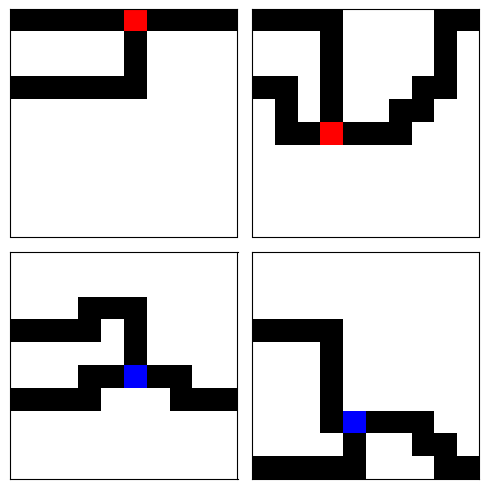

In [5]:
# Show dataset circuits

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
for idx, ax in enumerate(axes.flat):
    ax.imshow(argmaxedDataset[idx], cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [6]:
# Set truthtable embedder

class RowEmbedder(nn.Module):
    def __init__(self, num_categories, vector_length, embedding_dim):
        super().__init__()
        self.shared_embed = nn.Embedding(num_categories, embedding_dim)
        self.position_weights = nn.Parameter(torch.ones(vector_length, embedding_dim))
        self.position_bias = nn.Parameter(torch.zeros(vector_length, embedding_dim))
        
    def forward(self, x):
        # x shape: [batch_size, vector_length]
        shared = self.shared_embed(x)  # [batch_size, vector_length, emb_dim]
        # Apply position-specific scaling and shifting
        return shared * self.position_weights + self.position_bias
    

class TabularTransformer(nn.Module):
    def __init__(self, num_categories, num_features, d_model):
        super().__init__()
        self.d_model = d_model

        self.row_embedding = RowEmbedder(num_categories, num_features, d_model) #num_categories, vector_length, embedding_dim

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model * num_features,
            nhead=8,
            dim_feedforward=2*d_model * num_features,
            batch_first=True,
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=6,
        )
    
    def forward(self, x):
        #batch_size, num_rows, num_cols = x.shape

        rows = self.row_embedding(x) #bs, rows, columns, embedding
        #rows = rows.mean(dim=2)
        rows = rows.flatten(start_dim=2) 
        
    
        transformed = self.transformer(rows)

        return transformed

transformer = TabularTransformer(3, 12, 16)

print("embedder created as transformer")
print(f"Embedded shape: {transformer(InitialLabels)[0].shape}")

embedder created as transformer
Embedded shape: torch.Size([4, 192])


In [7]:
# Set up scheduler

class CategoricalScheduler:
    def __init__(self, TrainSteps = 200, numCategories = 4, betaStart = 0.0001, betaEnd = 0.02):
        self.TrainSteps = TrainSteps
        self.noiseDevice = 'cpu'
        self.numCategories = numCategories

        self.betas = torch.linspace(betaStart, betaEnd, TrainSteps, device=self.noiseDevice)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def addNoise(self, imageBatch, time):
        bs, ch, w, h = imageBatch.shape

        with torch.no_grad():
            alpha_t = self.alpha_cumprod[time].view(-1, 1, 1, 1) # Translates shape (1,) -> (1, 1, 1, 1)

            # the per pixel probability distribution of the categories
            currentProbabilities = imageBatch

            # The chance of each state per pixel when noised            
            updatedProbabilities = currentProbabilities * alpha_t + (1 - alpha_t) / self.numCategories 
            updatedProbabilities = updatedProbabilities.permute(0, 2, 3, 1) # reshape such that it is flattened correctly below
            updatedProbabilities = updatedProbabilities.reshape(bs*w*h, self.numCategories)  
            

            # 1 Sample per value
            categoricalNoise = torch.multinomial(updatedProbabilities, 1, replacement=True)
            categoricalNoise = categoricalNoise.view(bs, w, h) # Shape: [bs, w, h]

            noisedImages = F.one_hot(categoricalNoise, num_classes=self.numCategories)
            noisedImages = noisedImages.permute(0, 3, 1, 2) # [bs, num_classes, w, h]

            return noisedImages

scheduler = CategoricalScheduler()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [128]:
# Create Diffuser

class CategoricalDiffusionModel(nn.Module):
    def __init__(self, imageSize, numCategories, embeddingSize, attentionHeads=8, guidanceProb=0.1):
        super().__init__()
        self.guidance_prob=guidanceProb
        self.model = UNet2DConditionModel(
            sample_size=imageSize, 
            in_channels=numCategories,  # Image channels
            out_channels=numCategories,
            cross_attention_dim=embeddingSize,  # Matches mbedding's token dim 
            attention_head_dim=attentionHeads,     # Smaller head dim for efficiency
            layers_per_block=2,       # how many ResNet layers to use per UNet block
            block_out_channels=(64, 64, 64), 
            down_block_types=(
                "CrossAttnDownBlock2D",  
                "CrossAttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
            ),
        )
        
    def forward(self, x, t, embedding):
        bs, ch, w, h = x.shape

        #Use guidance probability, to help the model learn that 'circuit behvaior' 
        # is a general feature and not specific to a particular embedding.
        if self.training:
            mask = torch.rand_like(embedding, device=x.device) < self.guidance_prob
            embedding[mask] = 0

        return self.model(x, t, encoder_hidden_states=embedding).sample

loss = []
model = CategoricalDiffusionModel(10, 4, 192).to(device)

In [ ]:
# Training Function

def trainCatModel(catModel, dataloader, epochs, embeddingModel, losses, PLOTUPDATES = True):
    catModel.train()
    updateRate = 10 # For plotting purposes

    loss_fn = nn.CrossEntropyLoss() #nn.MSELoss(reduction='sum')

    fig, ax = plt.subplots(figsize=(8, 5))
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

    for epoch in range(epochs):
        
        for batch, labels in dataloader:

            timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

            noisyImgs = scheduler.addNoise(batch, timesteps)

            embeddings = embeddingModel(labels)

            pred = model(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))
            pred = F.softmax(pred, dim=1) 

            loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

        if PLOTUPDATES:
            if epoch % updateRate == 0:
                clear_output(wait=True)  
                ax.clear()
                plt.plot(losses)
                plt.xlabel('Batch')
                display(fig)
    
    if PLOTUPDATES:
        clear_output(wait=True)  
        ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    if PLOTUPDATES:
        display(fig)

    return catModel, losses

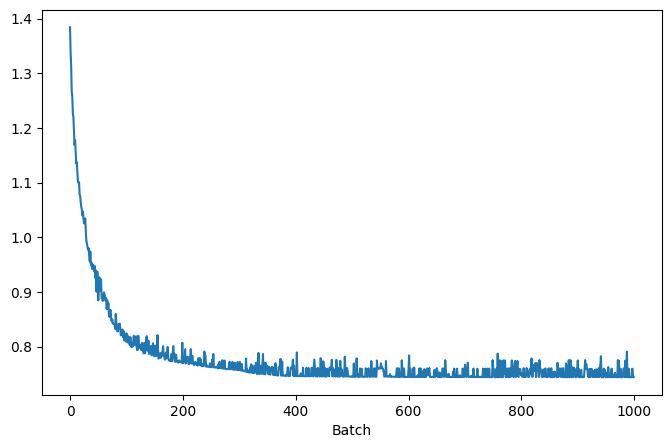

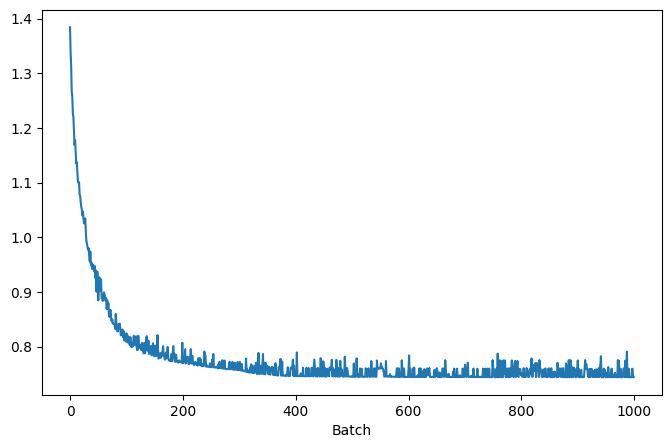

In [12]:
# FOR TEST, Train first

model, loss = trainCatModel(model, loader, 1000, transformer, loss)

So, in the above graph, it is clear that the accuracy won't go much below 0.8 and also it fluctates quite a bit up and down.

Things to test:
1. Accuracy for different timesteps
2. Whether the model is ignoring the embedded data, and just guessing for high loss.

other things to try:
1. Remove softmax in training. Cross entropy should already include it.
2. the order of inputs in the loss function might be reversed. If it is reversed, i would expect it to crash, but just to be sure, check out what happens if the order is flipped back.

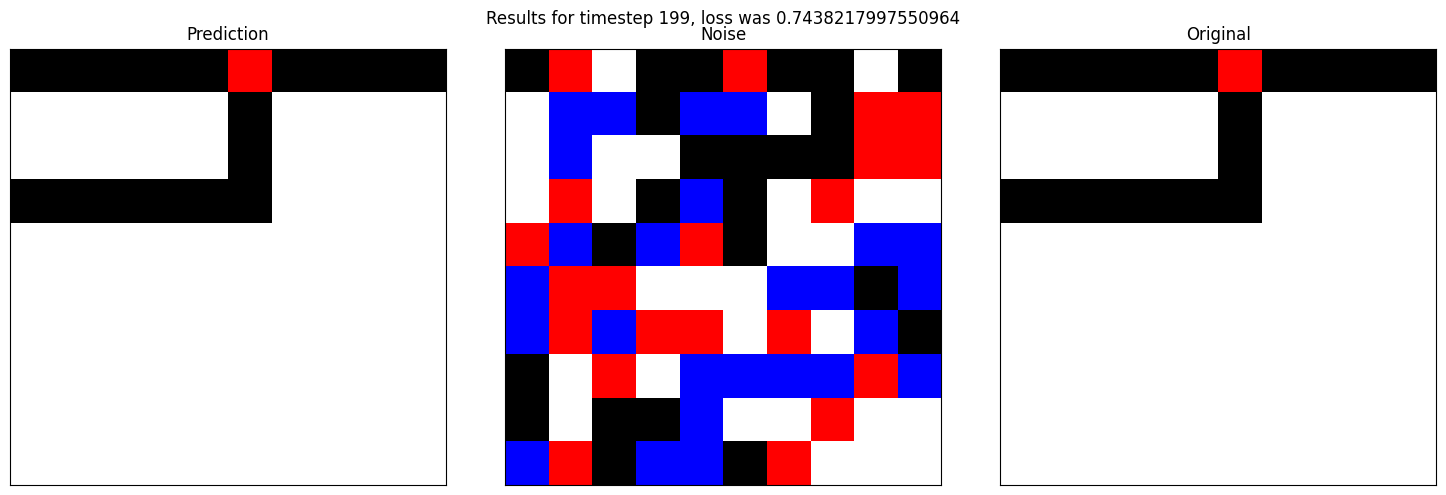

In [38]:
testX = InitialDataset[0:1]
t = 199
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
testPred = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

testSoft = F.softmax(testPred, dim=1)
loss_fn = nn.CrossEntropyLoss()

testMax = torch.argmax(testSoft, dim=1, keepdim=True).cpu().numpy().squeeze()

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes.flat
ax[0].imshow(testMax, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('Prediction')
ax[1].imshow(torch.argmax(testNoise, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[1].set_title('Noise')
ax[2].imshow(torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[2].set_title('Original')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.suptitle(f"Results for timestep {t}, loss was {loss_fn(testSoft, testX.to(device).argmax(axis=1))}")
plt.tight_layout()
plt.show()

Problems, 
1. The loss should be 0
2. Sometimes the predicted circuit is just guessed to be something completely different. There is a lot of infomration in the embedding, so it should be able to predict the circuit correctly. This is somewhat ok, as noise would be re-added during infernece. Ill show an incorrect guess below.

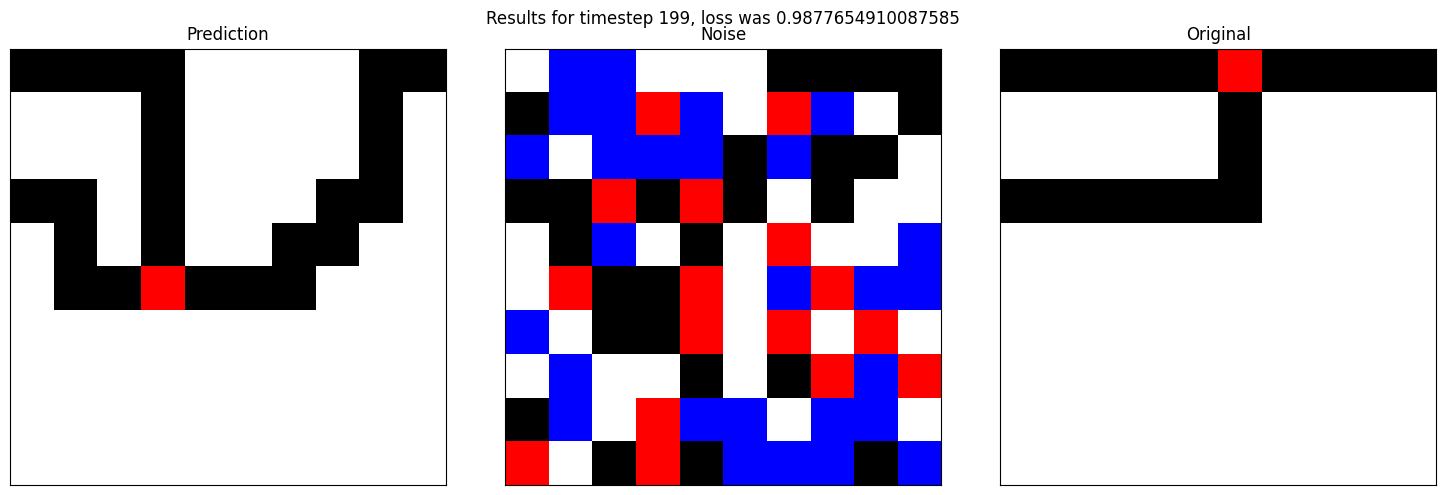

In [39]:
testX = InitialDataset[0:1]
t = 199
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
testPred = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

testSoft = F.softmax(testPred, dim=1)
loss_fn = nn.CrossEntropyLoss()

testMax = torch.argmax(testSoft, dim=1, keepdim=True).cpu().numpy().squeeze()

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes.flat
ax[0].imshow(testMax, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('Prediction')
ax[1].imshow(torch.argmax(testNoise, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[1].set_title('Noise')
ax[2].imshow(torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[2].set_title('Original')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.suptitle(f"Results for timestep {t}, loss was {loss_fn(testSoft, testX.to(device).argmax(axis=1))}")
plt.tight_layout()
plt.show()

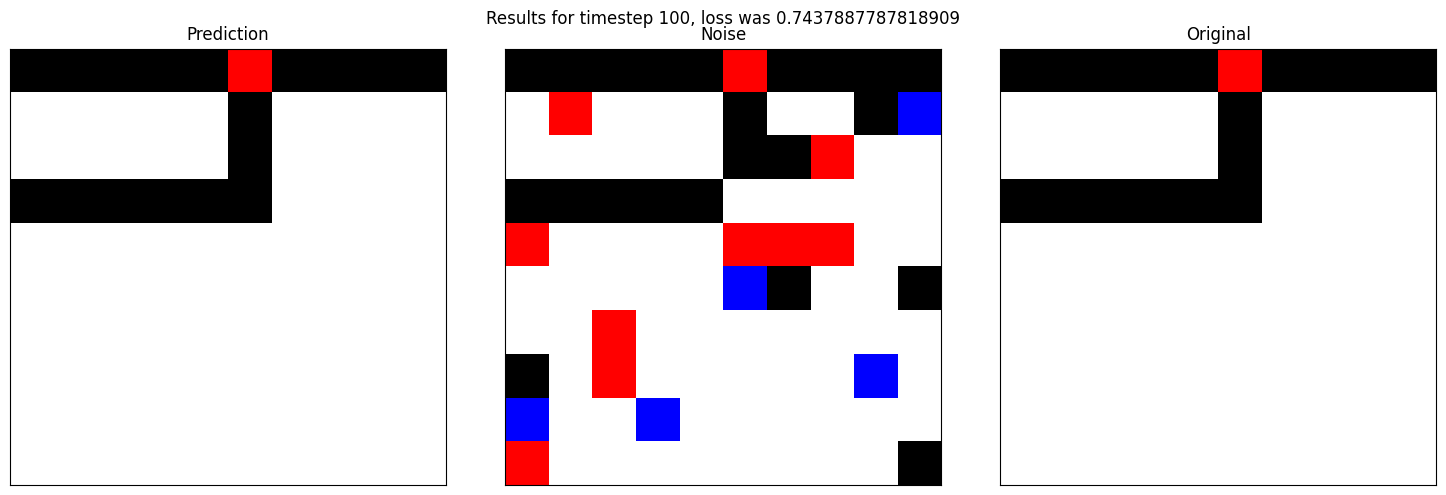

In [51]:
testX = InitialDataset[0:1]
t = 100
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
testPred = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

testSoft = F.softmax(testPred, dim=1)
loss_fn = nn.CrossEntropyLoss()

testMax = torch.argmax(testSoft, dim=1, keepdim=True).cpu().numpy().squeeze()

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes.flat
ax[0].imshow(testMax, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('Prediction')
ax[1].imshow(torch.argmax(testNoise, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[1].set_title('Noise')
ax[2].imshow(torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[2].set_title('Original')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.suptitle(f"Results for timestep {t}, loss was {loss_fn(testSoft, testX.to(device).argmax(axis=1))}")
plt.tight_layout()
plt.show()

For lower noise, more often correct predicion. Good

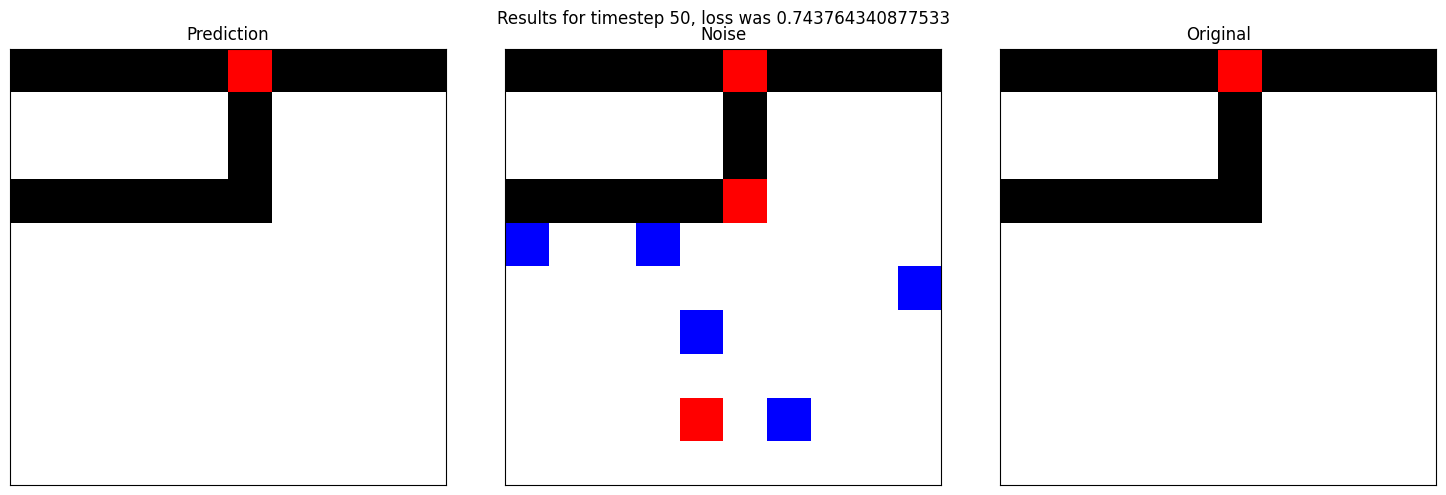

In [62]:
testX = InitialDataset[0:1]
t = 50
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
testPred = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

testSoft = F.softmax(testPred, dim=1)
loss_fn = nn.CrossEntropyLoss()

testMax = torch.argmax(testSoft, dim=1, keepdim=True).cpu().numpy().squeeze()

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes.flat
ax[0].imshow(testMax, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('Prediction')
ax[1].imshow(torch.argmax(testNoise, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[1].set_title('Noise')
ax[2].imshow(torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[2].set_title('Original')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.suptitle(f"Results for timestep {t}, loss was {loss_fn(testSoft, testX.to(device).argmax(axis=1))}")
plt.tight_layout()
plt.show()

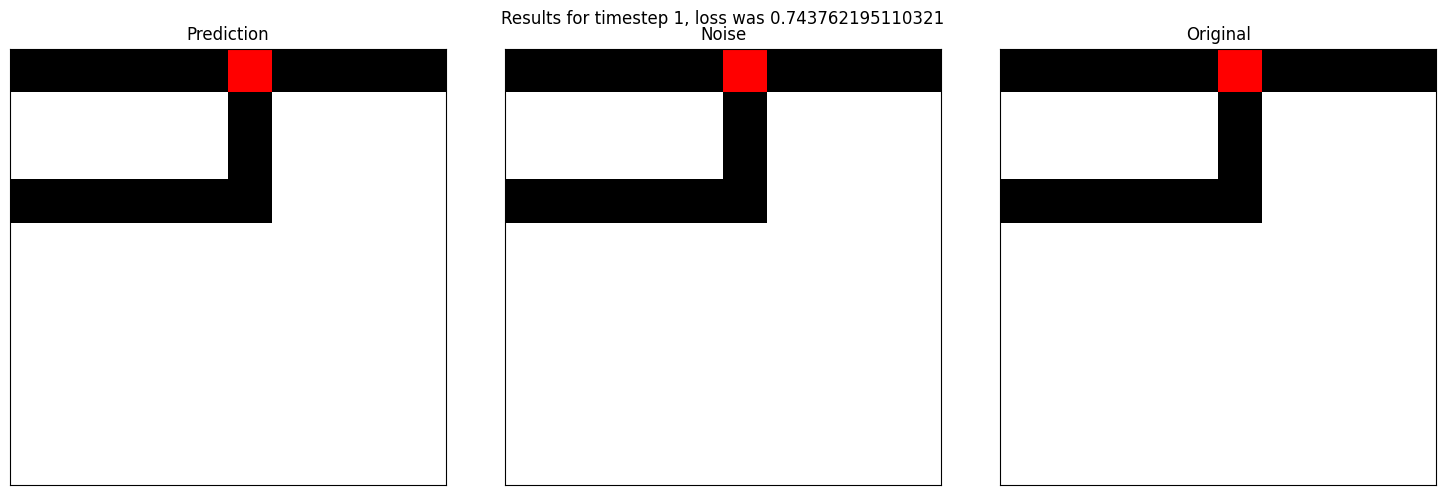

In [65]:
testX = InitialDataset[0:1]
t = 1
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
testPred = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

testSoft = F.softmax(testPred, dim=1)
loss_fn = nn.CrossEntropyLoss()

testMax = torch.argmax(testSoft, dim=1, keepdim=True).cpu().numpy().squeeze()

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes.flat
ax[0].imshow(testMax, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('Prediction')
ax[1].imshow(torch.argmax(testNoise, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[1].set_title('Noise')
ax[2].imshow(torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[2].set_title('Original')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.suptitle(f"Results for timestep {t}, loss was {loss_fn(testSoft, testX.to(device).argmax(axis=1))}")
plt.tight_layout()
plt.show()

__________
Now to check loss function

In [ ]:
testX = InitialDataset[0:1]
t = 1
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
# testPred = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

# testSoft = F.softmax(testPred, dim=1)
# loss_fn = nn.CrossEntropyLoss()

# testMax = torch.argmax(testSoft, dim=1, keepdim=True).cpu().numpy().squeeze()

loss_fn(testX.to(device), testX.to(device).argmax(axis=1))

tensor(0.7437, device='cuda:0')

huh...

In [76]:
testX = InitialDataset[0:1]
t = 1
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
# testPred = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

# testSoft = F.softmax(testPred, dim=1)
# loss_fn = nn.CrossEntropyLoss()

# testMax = torch.argmax(testSoft, dim=1, keepdim=True).cpu().numpy().squeeze()

#loss_fn(testX.to(device).argmax(axis=1).float(), testX.to(device))

log_probs = torch.log(testX.to(device) + 1e-8)
nn.NLLLoss()(log_probs, testX.to(device).argmax(axis=1))


tensor(0., device='cuda:0')

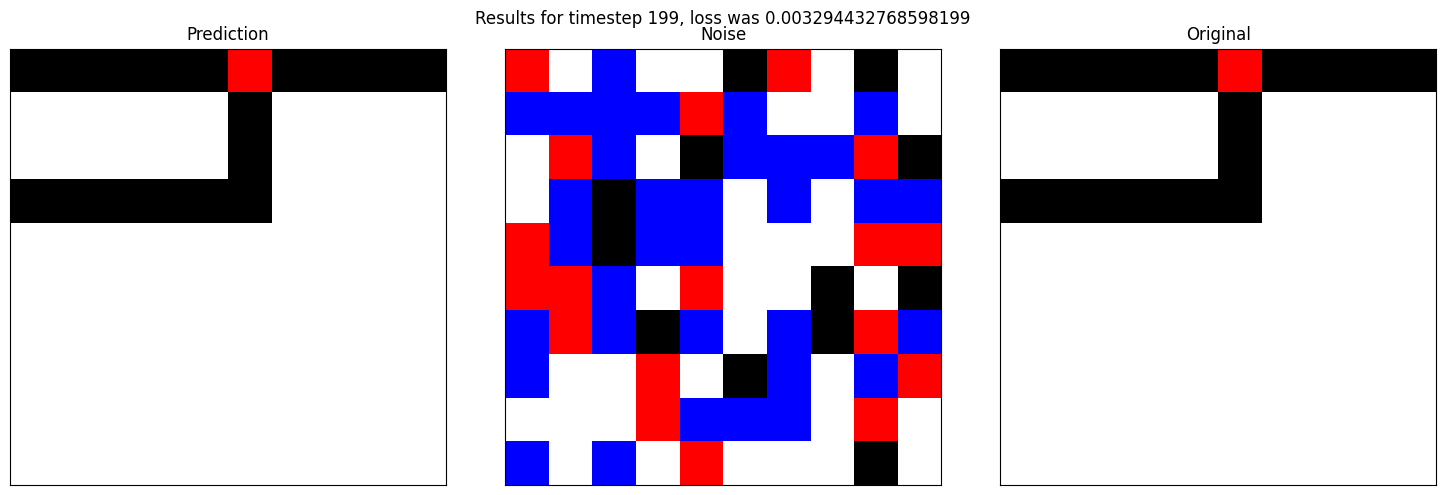

In [86]:
testX = InitialDataset[0:1]
t = 199
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
testPred = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

testSoft = F.softmax(testPred, dim=1)

testMax = torch.argmax(testSoft, dim=1, keepdim=True).cpu().numpy().squeeze()

#loss_fn(testX.to(device).argmax(axis=1).float(), testX.to(device))

log_probs = torch.log(testSoft.to(device) + 1e-8)


cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes.flat
ax[0].imshow(testMax, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('Prediction')
ax[1].imshow(torch.argmax(testNoise, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[1].set_title('Noise')
ax[2].imshow(torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[2].set_title('Original')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])


fig.suptitle(f"Results for timestep {t}, loss was {nn.NLLLoss()(log_probs, testX.to(device).argmax(axis=1))}")
plt.tight_layout()
plt.show()

Now the error is close to zero when prediction is correct, and high when predicion is incorrect.

But that is only when softmax is performed. Without doing softmax the error above returns NAN.

After softmax values sum to about 1. If i train the model without using softmax, but instead guessing the softmaxed values directly, can i remove the softmax for NLL?

In [87]:
# STILL TRAINING ON CROSSENTROPY HERE, JUST REMOVING SOFTMAX FOR NOW

def trainCatModel(catModel, dataloader, epochs, embeddingModel, losses, PLOTUPDATES = True):
    catModel.train()
    updateRate = 10 # For plotting purposes

    loss_fn = nn.CrossEntropyLoss() #nn.MSELoss(reduction='sum')

    fig, ax = plt.subplots(figsize=(8, 5))
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

    for epoch in range(epochs):
        
        for batch, labels in dataloader:

            timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

            noisyImgs = scheduler.addNoise(batch, timesteps)

            embeddings = embeddingModel(labels)

            pred = model(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))

            loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

        if PLOTUPDATES:
            if epoch % updateRate == 0:
                clear_output(wait=True)  
                ax.clear()
                plt.plot(losses)
                plt.xlabel('Batch')
                display(fig)
    
    if PLOTUPDATES:
        clear_output(wait=True)  
        ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    if PLOTUPDATES:
        display(fig)

    return catModel, losses

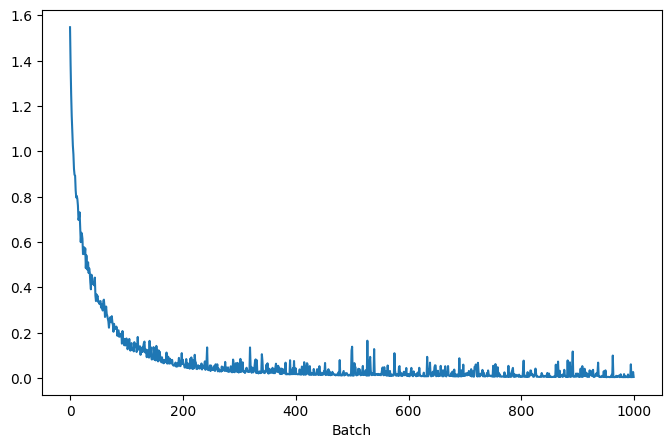

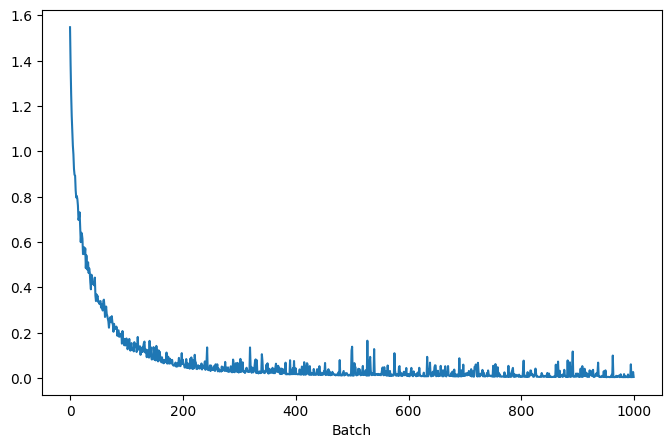

In [89]:
# FOR TEST, Train first

model, loss = trainCatModel(model, loader, 1000, transformer, loss)

This has allowed the model to get much lower values with crossentropy, but i suspect this isn't compatible with currecnt infrence code

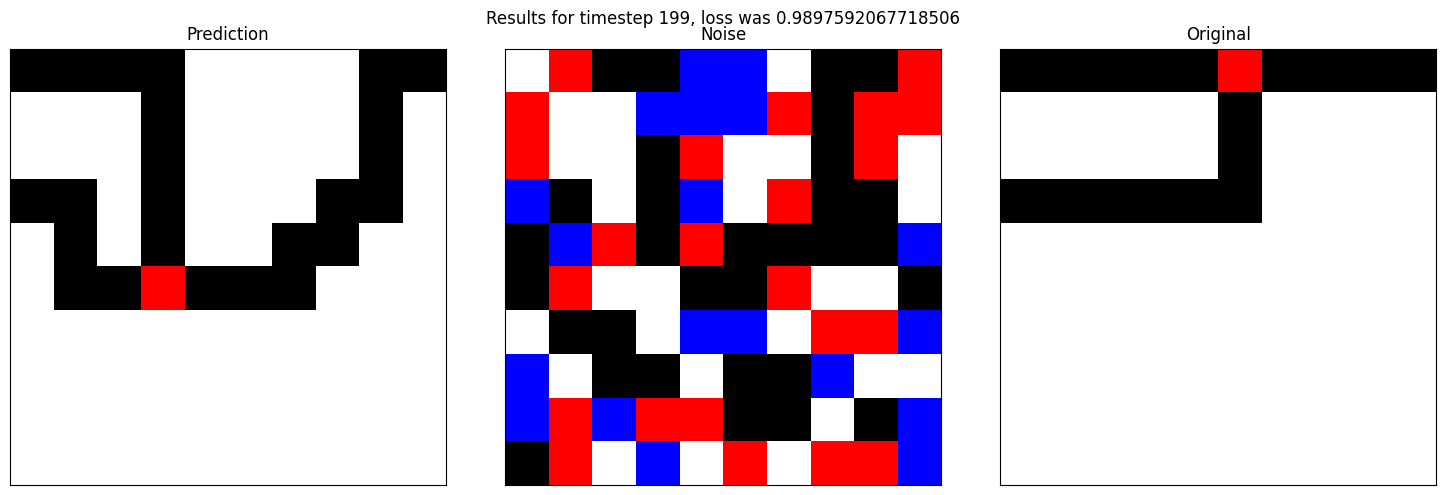

In [109]:
testX = InitialDataset[0:1]
t = 199
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
testPred = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

loss_fn = nn.CrossEntropyLoss()

testMax = torch.argmax(testPred, dim=1, keepdim=True).cpu().numpy().squeeze()

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes.flat
ax[0].imshow(testMax, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('Prediction')
ax[1].imshow(torch.argmax(testNoise, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[1].set_title('Noise')
ax[2].imshow(torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[2].set_title('Original')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.suptitle(f"Results for timestep {t}, loss was {loss_fn(testPred, testX.to(device).argmax(axis=1))}")
plt.tight_layout()
plt.show()

it works, loss is mostly reasonable,

But what about adding noise,  now that prediction isn't probabilities

In [112]:
testX = InitialDataset[0:1]
t = 199
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
testPred1 = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

t = 100
timeStep = torch.tensor([t])
testNoise = scheduler.addNoise(testPred1.to('cpu'), timeStep)
testPred2 = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

t = 1
timeStep = torch.tensor([t])
testNoise = scheduler.addNoise(testPred2, timeStep)
testPred3 = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

loss_fn = nn.CrossEntropyLoss()

testMax1 = torch.argmax(testPred1, dim=1, keepdim=True).cpu().numpy().squeeze()
testMax2 = torch.argmax(testPred2, dim=1, keepdim=True).cpu().numpy().squeeze()
testMax3 = torch.argmax(testPred3, dim=1, keepdim=True).cpu().numpy().squeeze()

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

ax = axes.flat
ax[0].imshow(testMax1, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('PredictionFinal')
ax[1].imshow(torch.argmax(testNoise, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[1].set_title('Noise')
ax[2].imshow(torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[2].set_title('Original')
ax[0].imshow(testMax2, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('PredictionFirst')
ax[0].imshow(testMax3, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('PredictionSecond')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.suptitle(f"Results for timestep {t}, loss was {loss_fn(testPred, testX.to(device).argmax(axis=1))}")
plt.tight_layout()
plt.show()

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

^Does not work

In [116]:
# STILL TRAINING ON CROSSENTROPY HERE, JUST REMOVING SOFTMAX FOR NOW

def trainCatModel(catModel, dataloader, epochs, embeddingModel, losses, PLOTUPDATES = True):
    catModel.train()
    updateRate = 10 # For plotting purposes

    loss_fn = nn.NLLLoss()

    fig, ax = plt.subplots(figsize=(8, 5))
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

    for epoch in range(epochs):
        
        for batch, labels in dataloader:

            timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

            noisyImgs = scheduler.addNoise(batch, timesteps)

            embeddings = embeddingModel(labels)

            pred = model(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))

            loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

        if PLOTUPDATES:
            if epoch % updateRate == 0:
                clear_output(wait=True)  
                ax.clear()
                plt.plot(losses)
                plt.xlabel('Batch')
                display(fig)
    
    if PLOTUPDATES:
        clear_output(wait=True)  
        ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    if PLOTUPDATES:
        display(fig)

    return catModel, losses

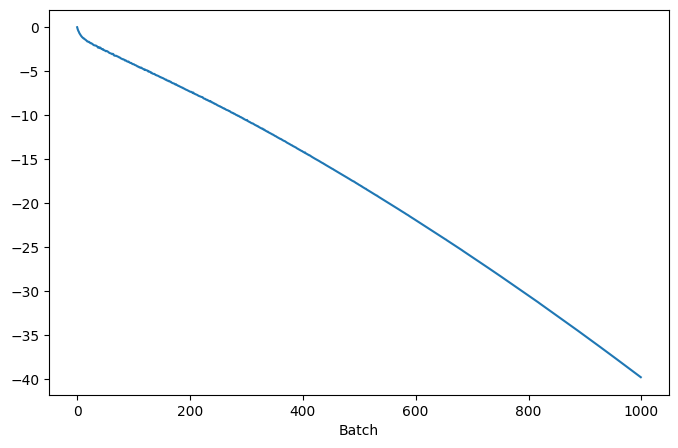

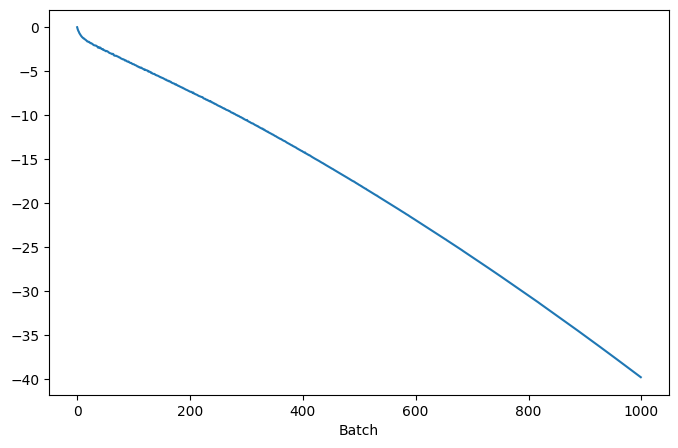

In [117]:
model, loss = trainCatModel(model, loader, 1000, transformer, loss)

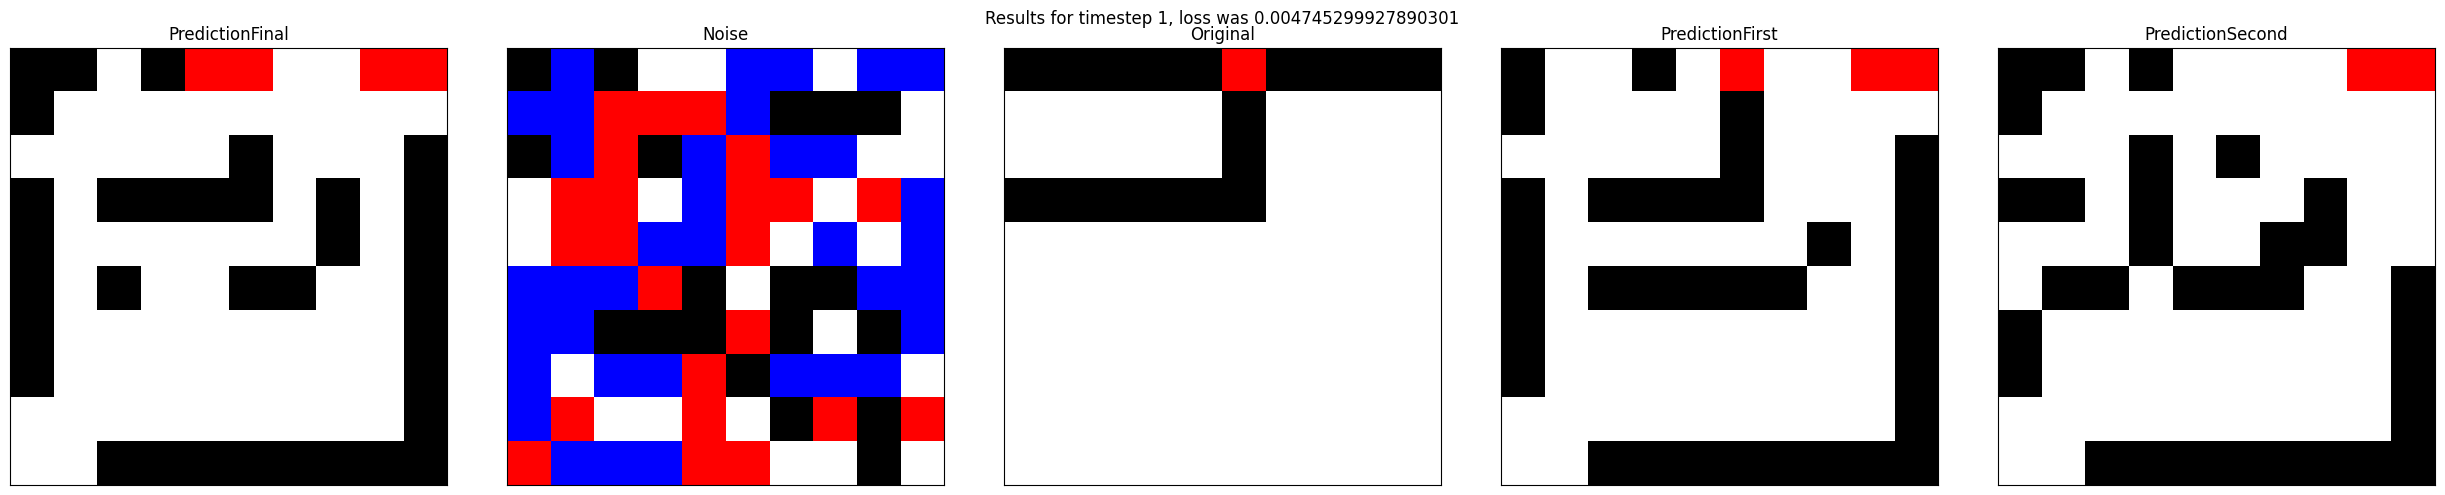

In [121]:
testX = InitialDataset[0:1]
t = 199
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
testPred1 = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

t = 100
timeStep = torch.tensor([t])
testNoise = scheduler.addNoise(testPred1.to('cpu'), timeStep)
testPred2 = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

t = 1
timeStep = torch.tensor([t])
testNoise = scheduler.addNoise(testPred2.to('cpu'), timeStep)
testPred3 = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

loss_fn = nn.CrossEntropyLoss()

testMax1 = torch.argmax(testPred1, dim=1, keepdim=True).cpu().numpy().squeeze()
testMax2 = torch.argmax(testPred2, dim=1, keepdim=True).cpu().numpy().squeeze()
testMax3 = torch.argmax(testPred3, dim=1, keepdim=True).cpu().numpy().squeeze()

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

ax = axes.flat
ax[0].imshow(testMax1, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('PredictionFinal')
ax[1].imshow(torch.argmax(testNoise, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[1].set_title('Noise')
ax[2].imshow(torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[2].set_title('Original')
ax[3].imshow(testMax2, cmap=cmap, vmin=0, vmax=3)
ax[3].set_title('PredictionFirst')
ax[4].imshow(testMax3, cmap=cmap, vmin=0, vmax=3)
ax[4].set_title('PredictionSecond')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.suptitle(f"Results for timestep {t}, loss was {loss_fn(testPred, testX.to(device).argmax(axis=1))}")
plt.tight_layout()
plt.show()

try readding softmax

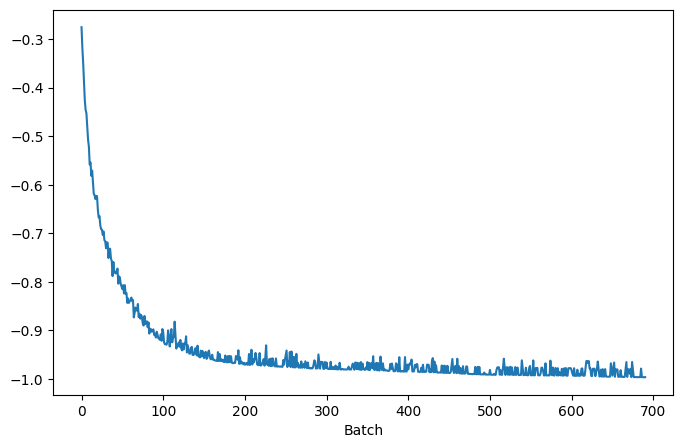

KeyboardInterrupt: 

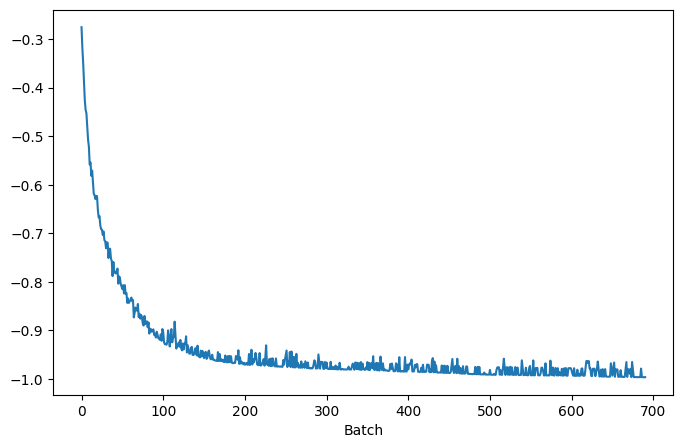

In [123]:
# STILL TRAINING ON CROSSENTROPY HERE, JUST REMOVING SOFTMAX FOR NOW

def trainCatModel(catModel, dataloader, epochs, embeddingModel, losses, PLOTUPDATES = True):
    catModel.train()
    updateRate = 10 # For plotting purposes

    loss_fn = nn.NLLLoss()

    fig, ax = plt.subplots(figsize=(8, 5))
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

    for epoch in range(epochs):
        
        for batch, labels in dataloader:

            timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

            noisyImgs = scheduler.addNoise(batch, timesteps)

            embeddings = embeddingModel(labels)

            pred = model(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))
            pred = F.softmax(pred, dim=1) 

            loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

        if PLOTUPDATES:
            if epoch % updateRate == 0:
                clear_output(wait=True)  
                ax.clear()
                plt.plot(losses)
                plt.xlabel('Batch')
                display(fig)
    
    if PLOTUPDATES:
        clear_output(wait=True)  
        ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    if PLOTUPDATES:
        display(fig)

    return catModel, losses

model, loss = trainCatModel(model, loader, 1000, transformer, loss)

This loss is also negative. which seems bad.

i forgot about taking the logarithm of the probabilities.

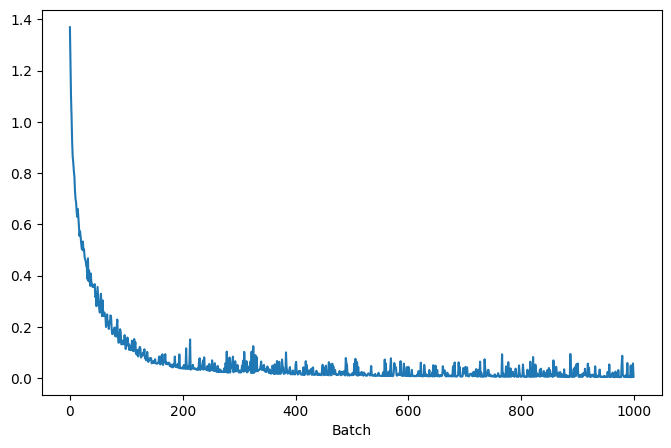

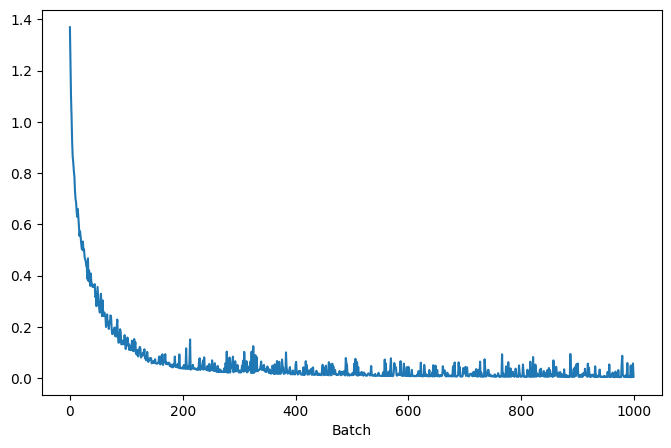

In [125]:
# STILL TRAINING ON CROSSENTROPY HERE, JUST REMOVING SOFTMAX FOR NOW

def trainCatModel(catModel, dataloader, epochs, embeddingModel, losses, PLOTUPDATES = True):
    catModel.train()
    updateRate = 10 # For plotting purposes

    loss_fn = nn.NLLLoss()

    fig, ax = plt.subplots(figsize=(8, 5))
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

    for epoch in range(epochs):
        
        for batch, labels in dataloader:

            timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

            noisyImgs = scheduler.addNoise(batch, timesteps)

            embeddings = embeddingModel(labels)

            pred = model(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))
            pred = F.softmax(pred, dim=1) 
            pred = torch.log(pred.to(device) + 1e-8)

            loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

        if PLOTUPDATES:
            if epoch % updateRate == 0:
                clear_output(wait=True)  
                ax.clear()
                plt.plot(losses)
                plt.xlabel('Batch')
                display(fig)
    
    if PLOTUPDATES:
        clear_output(wait=True)  
        ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    if PLOTUPDATES:
        display(fig)

    return catModel, losses

model, loss = trainCatModel(model, loader, 1000, transformer, loss)

Lets think about this for a bit.

I do need to use softmax, for noise thing due to sampling multinomial distribution.

So maybe above is fine, but taking both softmax and log of prediction feels weird.

Maybe there is still something i haven't given a proper try. Training with crossentropy(prediction, truth) and using softmax before adding noise

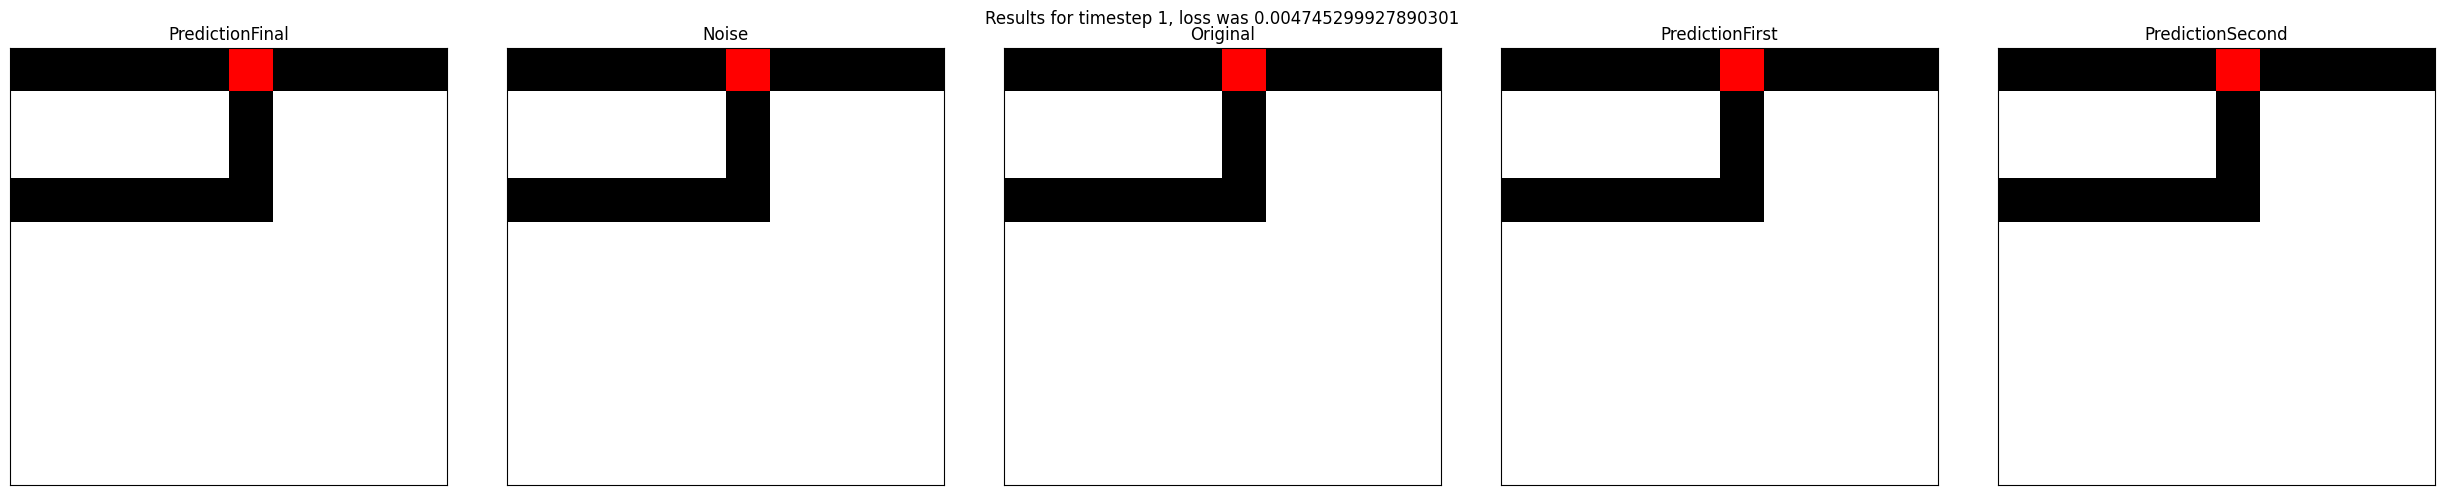

In [127]:
# NLL from above

testX = InitialDataset[0:1]
t = 199
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
testPred1 = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))
testPred1 = F.softmax(testPred1, dim=1) 

t = 100
timeStep = torch.tensor([t])
testNoise = scheduler.addNoise(testPred1.to('cpu'), timeStep)
testPred2 = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))
testPred2 = F.softmax(testPred2, dim=1) 

t = 1
timeStep = torch.tensor([t])
testNoise = scheduler.addNoise(testPred2.to('cpu'), timeStep)
testPred3 = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

loss_fn = nn.CrossEntropyLoss()

testMax1 = torch.argmax(testPred1, dim=1, keepdim=True).cpu().numpy().squeeze()
testMax2 = torch.argmax(testPred2, dim=1, keepdim=True).cpu().numpy().squeeze()
testMax3 = torch.argmax(testPred3, dim=1, keepdim=True).cpu().numpy().squeeze()

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

ax = axes.flat
ax[0].imshow(testMax1, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('PredictionFinal')
ax[1].imshow(torch.argmax(testNoise, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[1].set_title('Noise')
ax[2].imshow(torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[2].set_title('Original')
ax[3].imshow(testMax2, cmap=cmap, vmin=0, vmax=3)
ax[3].set_title('PredictionFirst')
ax[4].imshow(testMax3, cmap=cmap, vmin=0, vmax=3)
ax[4].set_title('PredictionSecond')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.suptitle(f"Results for timestep {t}, loss was {loss_fn(testPred, testX.to(device).argmax(axis=1))}")
plt.tight_layout()
plt.show()

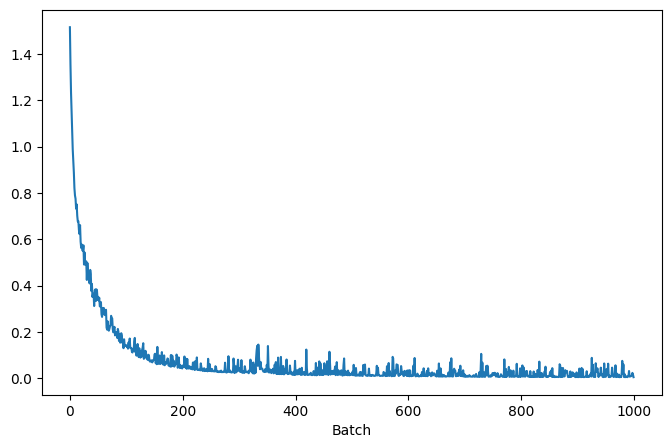

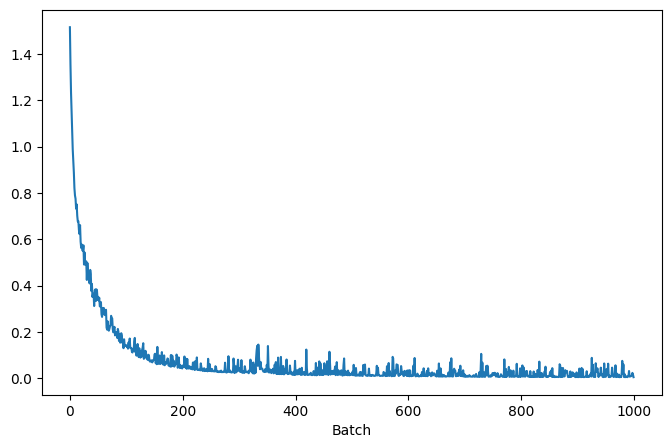

In [129]:
# redoing the raw cross entropy one

def trainCatModel(catModel, dataloader, epochs, embeddingModel, losses, PLOTUPDATES = True):
    catModel.train()
    updateRate = 10 # For plotting purposes

    loss_fn = nn.CrossEntropyLoss() #nn.MSELoss(reduction='sum')

    fig, ax = plt.subplots(figsize=(8, 5))
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

    for epoch in range(epochs):
        
        for batch, labels in dataloader:

            timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

            noisyImgs = scheduler.addNoise(batch, timesteps)

            embeddings = embeddingModel(labels)

            pred = model(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))

            loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

        if PLOTUPDATES:
            if epoch % updateRate == 0:
                clear_output(wait=True)  
                ax.clear()
                plt.plot(losses)
                plt.xlabel('Batch')
                display(fig)
    
    if PLOTUPDATES:
        clear_output(wait=True)  
        ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    if PLOTUPDATES:
        display(fig)

    return catModel, losses

model, loss = trainCatModel(model, loader, 1000, transformer, loss)

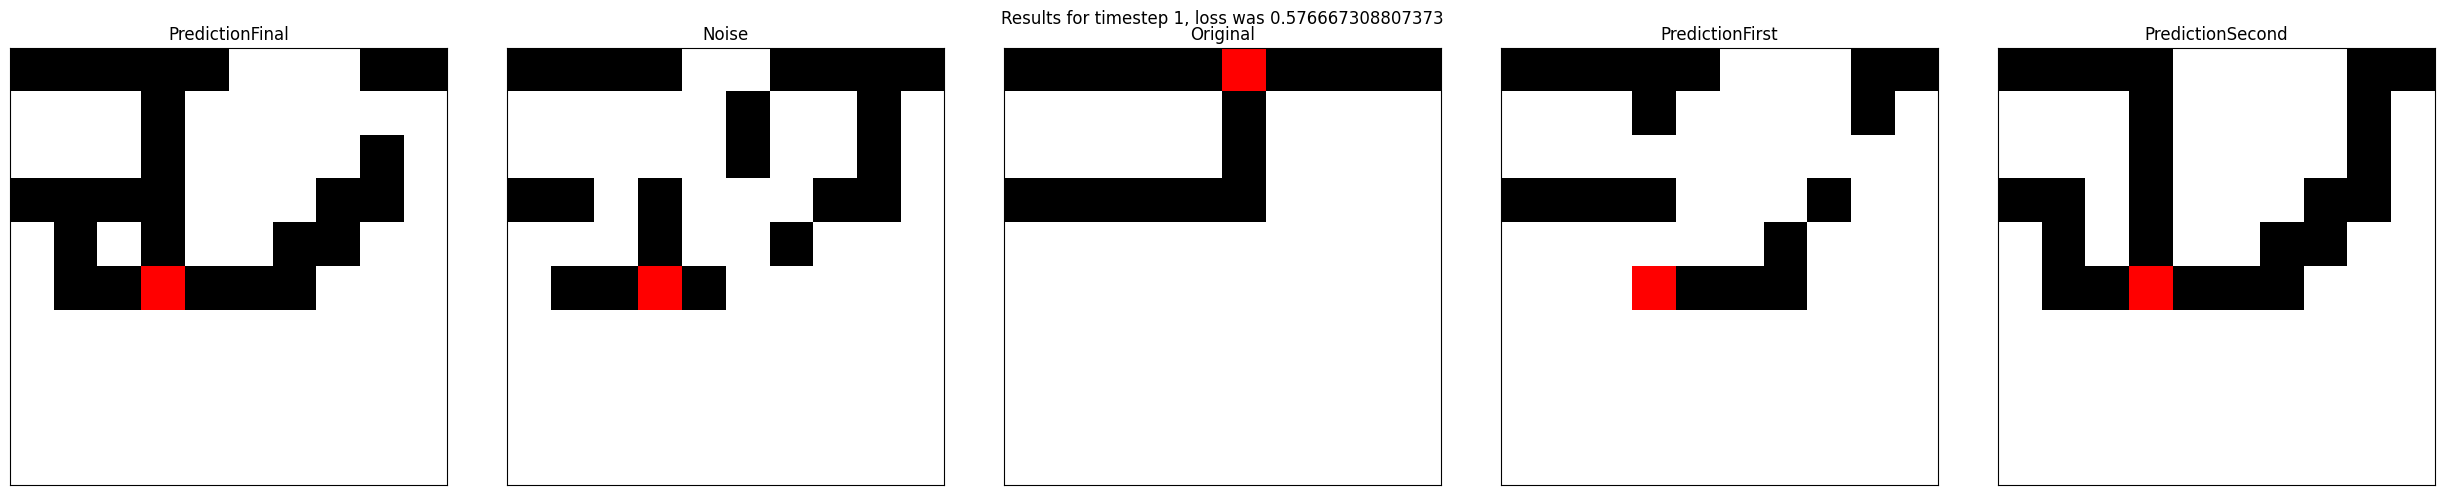

In [153]:
# NLL from above

testX = InitialDataset[0:1]
t = 199
timeStep = torch.tensor([t])
embedding = transformer(InitialLabels[0:1])

testNoise = scheduler.addNoise(testX, timeStep)
testPred1 = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))
testPred1 = F.softmax(testPred1, dim=1) 

t = 100
timeStep = torch.tensor([t])
testNoise = scheduler.addNoise(testPred1.to('cpu'), timeStep)
testPred2 = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))
testPred2 = F.softmax(testPred2, dim=1) 

t = 1
timeStep = torch.tensor([t])
testNoise = scheduler.addNoise(testPred2.to('cpu'), timeStep)
testPred3 = model(testNoise.float().to(device), timeStep.to(device), embedding.to(device))

loss_fn = nn.CrossEntropyLoss()

testMax1 = torch.argmax(testPred1, dim=1, keepdim=True).cpu().numpy().squeeze()
testMax2 = torch.argmax(testPred2, dim=1, keepdim=True).cpu().numpy().squeeze()
testMax3 = torch.argmax(testPred3, dim=1, keepdim=True).cpu().numpy().squeeze()

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

ax = axes.flat
ax[0].imshow(testMax1, cmap=cmap, vmin=0, vmax=3)
ax[0].set_title('PredictionFinal')
ax[1].imshow(torch.argmax(testNoise, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[1].set_title('Noise')
ax[2].imshow(torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze(), cmap=cmap, vmin=0, vmax=3)
ax[2].set_title('Original')
ax[3].imshow(testMax2, cmap=cmap, vmin=0, vmax=3)
ax[3].set_title('PredictionFirst')
ax[4].imshow(testMax3, cmap=cmap, vmin=0, vmax=3)
ax[4].set_title('PredictionSecond')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.suptitle(f"Results for timestep {t}, loss was {loss_fn(testPred3, testX.to(device).argmax(axis=1))}")
plt.tight_layout()
plt.show()

In [158]:
#fig.suptitle(f"Results for timestep {t}, loss was {loss_fn(testPred3, testX.to(device).argmax(axis=1))}")

testSoft = F.softmax(testPred3, dim=1) 
log_probs = torch.log(testSoft.to(device) + 1e-8)
#log_probs = torch.log(testPred3.to(device) + 1e-8)

nn.NLLLoss()(log_probs, testX.to(device).argmax(axis=1))

tensor(0.5767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

Between Nll and and cross entropy, both work.
Loss is the same for both methods. Continue using cross entropy, but update the training loop to not include softmax.

About the fluctiations in loss at the end of training:

This is becuase it is hard to guess correctly at high timesteps. For typical diffusion it is the loss equivalent to predicting noise at low timesteps